In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dv = np.load("data/cl_kkgal_input.npy")
ells = np.arange(len(dv))
zz, nz = np.load("data/dndz_input_z3_lensing_field_lsstlike.npy")

In [48]:
np.savetxt("data/dndz_class.txt", np.stack((zz, nz), axis=1))

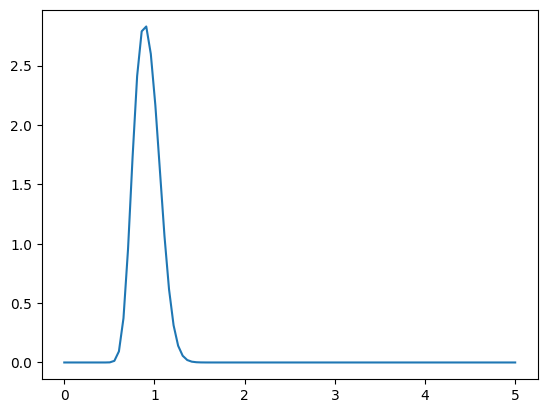

In [3]:
plt.plot(zz, nz)

In [55]:
from classy import Class
lmax = 2200
base_params = {
    # Saídas necessárias (CMB + LSS)
    'modes': 's',
    'output': 'tCl, pCl, lCl, mPk, nCl, sCl',
    'lensing': 'yes',
    'l_max_scalars': lmax,
    'l_max_lss': lmax,
    'number_count_contributions': 'density',

    # Energia escura via fld
    'Omega_Lambda': 0,
    'w0_fld': '-1.',
    'wa_fld': '0.0',

    # Espectro primordial (n_s fixo; sigma8 varia no loop)
    'n_s': 0.96,

    # Verbosidade e gauge
    'background_verbose': 0,
    'perturbations_verbose': 0,
    'gauge': 'Synchronous',

    # P(k) linear
    'z_pk': '1.0, 0.0',
    'P_k_max_h/Mpc': 10,
    'k_per_decade_for_pk': 30,
    'non linear': 'halofit',

    # Fundo
    'h': 0.673,
    'Omega_b': 0.05,

    # Seleção LSS (usando gaussian bin)
    # 'selection': 'gaussian',
    # 'selection_mean': '0.9',
    # 'selection_width': '0.1',

    'dNdz_selection': 'data/dndz_class.txt',

    'N_ncdm': 1,
    'm_ncdm': 0.06,
    'T_ncdm': 0.7137658555036082,
    'N_ur': 2.046,
}
Omega_nu_fid = 0.06/93.15/base_params['h']**2

def get_cl_kk(Omega_m, sigma_8):
    cosmo = Class()
    params = base_params.copy()
    params.update({
        'Omega_cdm': Omega_m - base_params['Omega_b'] - Omega_nu_fid,
        # 'sigma8': sigma_8,
        "A_s": 2e-9
    })
    
    cosmo.set(params)
    cosmo.compute()
    
    cl = cosmo.density_cl(lmax)
    Cl_kk  = np.asarray(cl['ll']['lens[1]-lens[1]'])
    ell = np.arange(len(Cl_kk))

    return ell, np.asarray(Cl_kk), cosmo  # retorna o cosmo se quiser reaproveitar

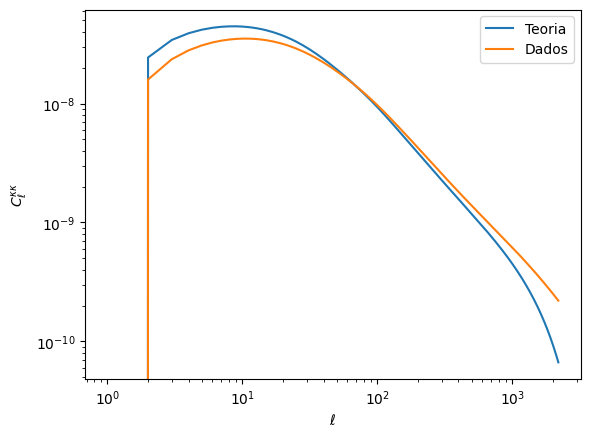

In [56]:
ell, cl_kk, _ = get_cl_kk(Omega_m=0.35, sigma_8=0.820)
fac = (ell**4 + 2*ell**3 - ell*2 - 2*ell)/4
# fac = 4/(ell*(ell+1))**2
# fac = (ell*(ell+1))**2/4
# fac = ell*(ell+1)/(2*np.pi)
plt.loglog(ell, fac*cl_kk, label="Teoria")
plt.loglog(ells, dv,        label="Dados")
plt.legend()
plt.xlabel("$\\ell$")
plt.ylabel("$C_\\ell^{\\kappa\\kappa}$")
plt.savefig("comparacao_cl_kk.pdf")

In [23]:
np.save("cl_kk_input_class.npy", fac*cl_kk)